In [4]:
import torch
import numpy as np
from torch.utils.data import DataLoader, Dataset

run_num = 1
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
directory = f"saved_models/run_{run_num}/"

## Construct Dataset

In [53]:

class GaussianDataset(Dataset):
    def __init__(self, num_samples, input_dim, cov, samples_per_obs, obs_trans = None):
        self.num_samples = num_samples
        self.input_dim = input_dim
        self.cov = cov

        self.o = []
        self.a = []
        # Generate input data (o)
        for _ in range(num_samples):
            obs = np.random.normal(size=(input_dim))
            if obs_trans is not None:
                obs = obs_trans(obs)

            for _ in range(samples_per_obs):

                # Generate output data (a) using the Gaussian distribution
                act = np.random.multivariate_normal(mean=obs, cov=self.cov)

                self.o.append(obs)
                self.a.append(act)

        print(f"Generated {len(self.o)} samples")


    def __len__(self):
        return len(self.o)
    
    def get_observations(self):
        return self.o

    def __getitem__(self, idx):
        o = torch.tensor(self.o[idx], dtype=torch.float32)
        a = torch.tensor(self.a[idx], dtype=torch.float32)
        return o, a
    
dataloader = torch.load(directory + f"test-dataloader-{run_num}.pth")


/tmp/ipykernel_270156/405164151.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dataloader = torch.load(directory + f"test-dataloader-{run_num}.pth")


### Optional Generate More Data

In [ ]:
"""
num_samples = 1000
action_dim = 2
samples_per_obs = 10
cov = np.loadtxt(directory + f"cov-{run_num}.txt")

test_dataset = GaussianDataset(num_samples, action_dim, cov, samples_per_obs)
"""

### Plot Dataset

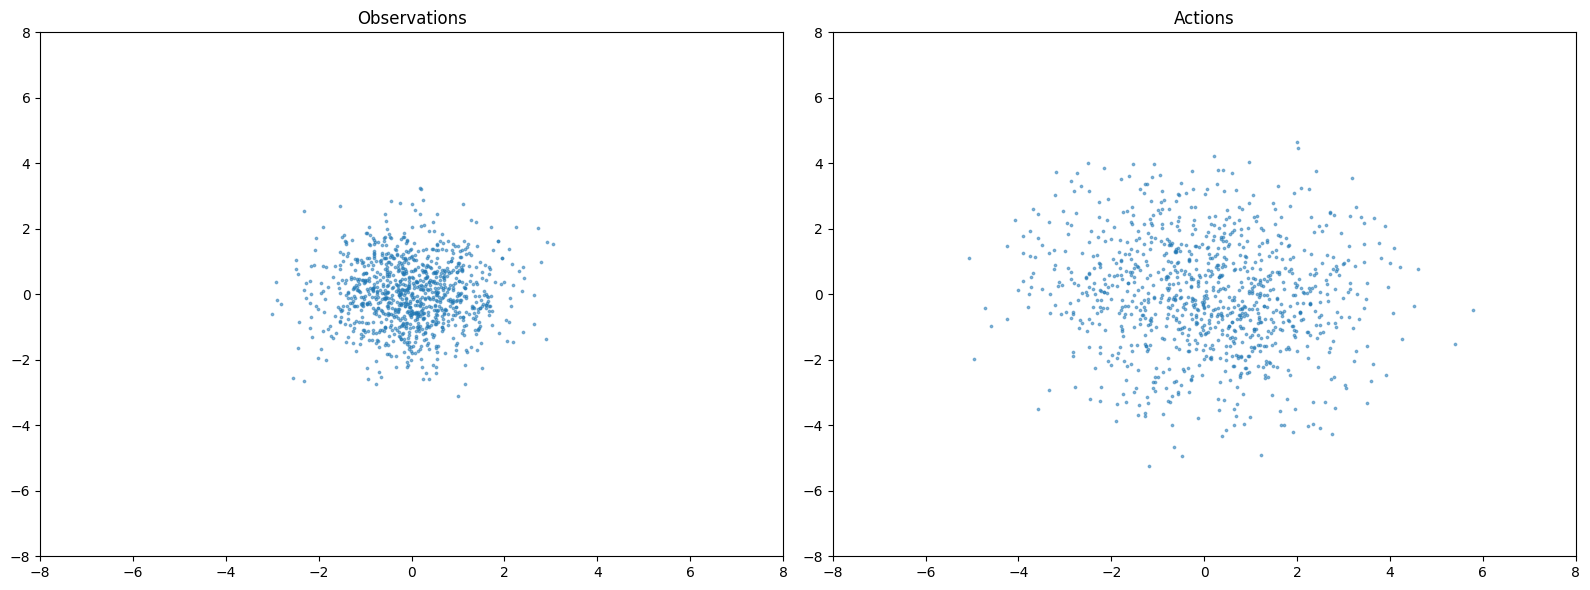

In [25]:

import matplotlib.pyplot as plt

obs = []
act = []

for batch in dataloader:
    o, a = batch
    obs.extend(o.numpy())
    act.extend(a.numpy())


# Create a new figure
fig = plt.figure(figsize=(16, 6))

# Create a subplot on the first column
plt.subplot(1, 2, 1)
plt.scatter(*zip(*obs), s=3, alpha=0.5)
plt.title('Observations')
plt.xlim(-8, 8)
plt.ylim(-8, 8)
# Create a subplot on the second column
plt.subplot(1, 2, 2)
plt.scatter(*zip(*act), s=3, alpha=0.5)
plt.title('Actions')
plt.xlim(-8, 8)
plt.ylim(-8, 8)
# Layout so plots do not overlap
plt.tight_layout()

# Display the plot
plt.show()

## Load the Model

In [27]:
import torch.nn as nn
from diffusers import UNet2DModel

import torch
import torch.nn as nn
import torch.nn.functional as F


class TimeEmbedding(nn.Module):
    def __init__(self, embedding_dim, max_period=10000):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.max_period = max_period

    def forward(self, t):
        half_dim = self.embedding_dim // 2
        emb = torch.cat([torch.sin(t * (10000 ** (torch.arange(half_dim, device=t.device) / half_dim))), 
                        torch.cos(t * (10000 ** (torch.arange(half_dim, device=t.device) / half_dim)))], dim=-1)
        return emb

class ClassConditionedMLP(nn.Module):
    def __init__(self, action_dim=2, class_emb_size=2, hidden_dim=64, num_layers=3, time_emb_dim=128):
        super().__init__()
        
        self.time_embedding = TimeEmbedding(time_emb_dim)
        
        # Input dimension: (action_dim + class_emb_size) + time_emb_dim
        input_dim = action_dim * 1 + class_emb_size * 1 + time_emb_dim
        output_dim = action_dim * 1  # Matches the output shape of the UNet
        
        # Define a simple MLP architecture
        layers = [nn.Linear(input_dim, hidden_dim), nn.ReLU()]
        for _ in range(num_layers - 1):
            layers.extend([nn.Linear(hidden_dim, hidden_dim), nn.ReLU()])
        layers.append(nn.Linear(hidden_dim, output_dim))
        
        self.mlp = nn.Sequential(*layers)
    
    def forward(self, obs, act, t):
        # Flatten input dimensions and prepare input for MLP
        act = torch.tensor(act).unsqueeze(1).unsqueeze(-1)  # Convert to tensor and shape (bs, 1, 2, 1)
        bs, ch, w, h = act.shape
        act_flat = act.view(bs, -1)  # Flatten to (bs, action_dim)
        
        class_cond = torch.tensor(obs)  # Convert to tensor (bs, class_emb_size)
        
        # Encode timestep
        t = torch.tensor(t).unsqueeze(-1)  # Convert timestep to tensor (bs, 1)

        t_emb = self.time_embedding(t)  # Encode timestep
        
        # Concatenate action, class conditioning, and encoded timestep
        mlp_input = torch.cat([act_flat, class_cond, t_emb], dim=1)  # Shape: (bs, input_dim)
        
        # Pass through MLP
        output = self.mlp(mlp_input)  # Shape: (bs, output_dim)
        
        # Reshape to match UNet's output: (bs, 1, action_dim, 1)
        return output.view(bs, 1, w, h)

model = torch.load(directory + f"MLP-model-{run_num}.pth").to(device)

/tmp/ipykernel_270156/3025566399.py:61: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(directory + f"MLP-model-{run_num}.pth").to(device)


## Eval Model

In [ ]:
device = "cuda"
model = torch.load(f"saved_models/MLP-model-{config.model_id}.pth").to(device)
model.eval()
val_loss = 0
with torch.no_grad():
    for batch in test_data_loader:
        obs, act = batch
        obs = obs.to(device)
        act = act.to(device)
        inputs = torch.cat((obs, act), dim=1)
        bs = inputs.shape[0]

        noise = torch.randn(act.shape, device=act.device)
        timesteps = torch.randint(
            0, noise_scheduler.config.num_train_timesteps, (bs,), device=act.device,
            dtype=torch.int64
        )
        noisy_actions = noise_scheduler.add_noise(act, noise, timesteps)
        noise_pred = model(obs, noisy_actions, timesteps).squeeze()
        loss = F.mse_loss(noise_pred, noise)
        val_loss += loss.item()

val_loss /= len(test_data_loader)

print(val_loss)